In [1]:
# This notebook identifies a golfball in radar data
# range_doppler_notebook has the basics of how to get the basics (what was I thinking when I wrote this)

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift # Might not need this
from radar_ffts import range_doppler_fft, range_doppler_sum
from cfar import cfar, clean_cfar
from radar_functions import range_doppler_map, get_measurement_parameters, cfar_map, save_range_doppler_map, save_cfar_map, get_data_files


c = 299792458 # metres per second - need this

In [2]:
# Making data lists
#moving_back_test = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
#one_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_1m_1_data.hdf5','r')
#two_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_2m_1_data.hdf5','r')

golfball_testset1 = '../4022S_data/golfball_testset1/'
session2_preface = '../4022S_data/session2/'
session3 = ['../4022S_data/session3/config1_rob/', '../4022S_data_session3/']

#tennis_ball_tests = get_data_files(session2_preface) # This works pretty well. Should make new folders for different tests/sets, but this works as a good basis

# There is CERTAINLY a way to do this faster but I dont have internet rn so oh well :/
# TODO: Find the right thing to do this
#initial_slow_tests = [h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-13-34_932_initialgolftest_slow.hdf5','r'),
 #                     h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-14-00_080_initialgolftest_slow.hdf5','r'),
  #                    h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-14-17_789_initialgolftest_slow.hdf5','r'),
   #                   h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-14-35_509_initialgolftest_slow.hdf5','r'),
    #                  h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-14-50_154_initialgolftest_slow.hdf5','r'),
     #                 h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-15-40_120_initialgolftest_slow.hdf5','r'),
      #                h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-15-55_306_initialgolftest_slow.hdf5','r')]

#initial_fast_tests = [h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-17-13_795_initialgolftest_fast.hdf5'),
 #                     h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-18-01_884_initialgolftest_fast.hdf5'),
  #                    h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-18-18_495_initialgolftest_fast.hdf5'),
   #                   h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-18-35_886_initialgolftest_fast.hdf5'),
    #                  h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-19-20_774_initialgolftest_fast.hdf5'),
     #                 h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-19-34_102_initialgolftest_fast.hdf5'),
      #                h5py.File(f'{golfball_testset1}Experiment_2024-09-13_14-19-47_106_initialgolftest_fast.hdf5'),]

tennis_ball_tests = [h5py.File(f'{session2_preface}Experiment_2024-09-18_18-16-00_327_tennisball_1.hdf5'),
                     h5py.File(f'{session2_preface}Experiment_2024-09-18_18-16-46_184_tennisball_2.hdf5'),
                     h5py.File(f'{session2_preface}Experiment_2024-09-18_18-17-22_976_tennisball_3.hdf5')]

#tinfoil_ball_tests = [h5py.File(f'{session2_preface}Experiment_2024-09-18_18-19-39_376_tinfoilball_1.hdf5'),
 #                    h5py.File(f'{session2_preface}Experiment_2024-09-18_18-20-04_723_tinfoilball_2.hdf5'),
  #                   h5py.File(f'{session2_preface}Experiment_2024-09-18_18-20-23_989_tinfoilball_3.hdf5'),]

#session3_rob_tests = [h5py.File(f'{session3[0]}Experiment_2024-09-21_11-31-15_734_tennis_ball_1.hdf5'),
 #                     h5py.File(f'{session3[0]}Experiment_2024-09-21_11-31-51_857_tennis_ball_2.hdf5'), # first two tests are tennis balls
  #                    h5py.File(f'{session3[0]}Experiment_2024-09-21_11-33-10_975_pinpongball.hdf5'),
   #                   h5py.File(f'{session3[0]}Experiment_2024-09-21_11-33-37_284_pinpongball.hdf5'),
    #                  h5py.File(f'{session3[0]}Experiment_2024-09-21_11-34-05_212_pinpongball.hdf5')]



c:\Users\harry\Documents\uni\2024S\EEE4022S\4022S_code\radar_functions.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks
c:\Users\harry\Documents\uni\2024S\EEE4022S\4022S_code\radar_functions.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks
c:\Users\harry\Documents\uni\2024S\EEE4022S\4022S_code\radar_functions.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks
c:\Users\harry\Documen

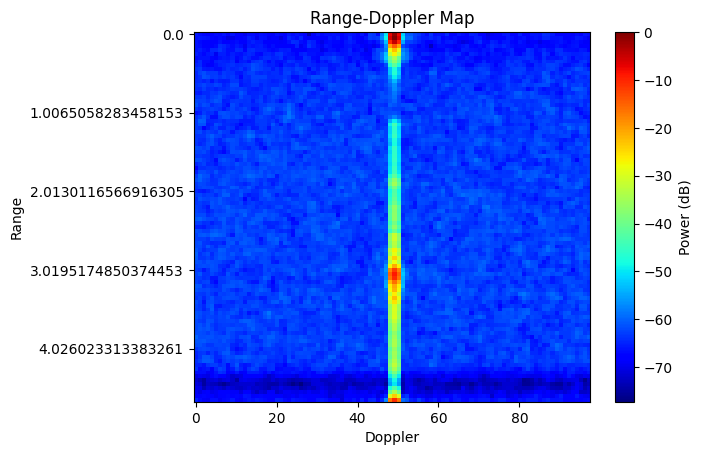

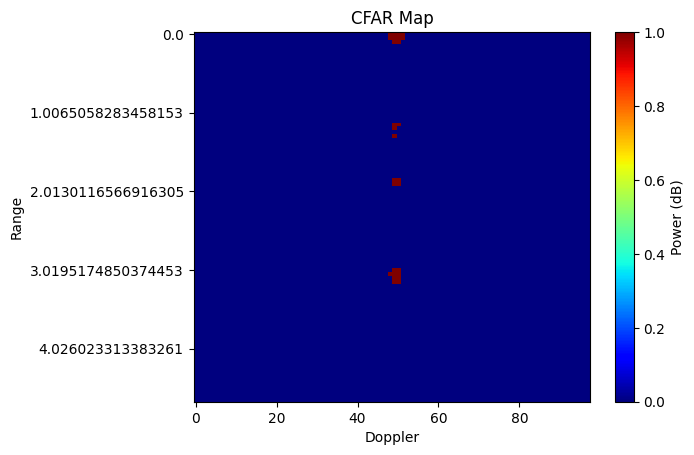

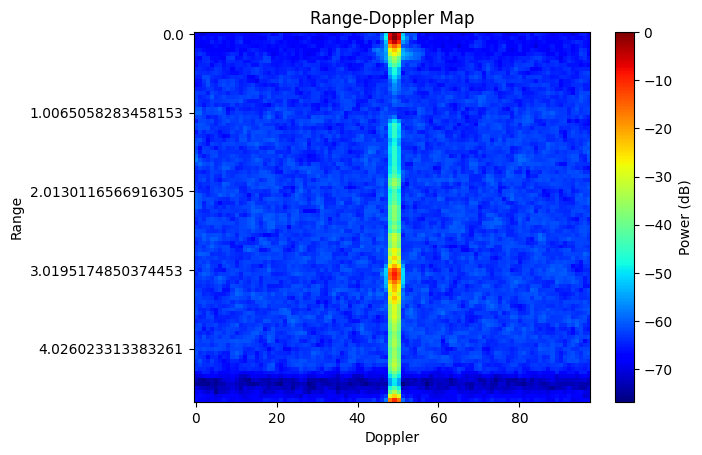

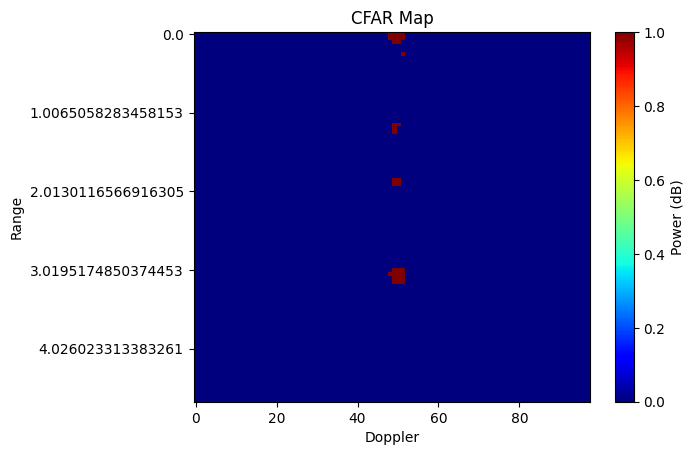

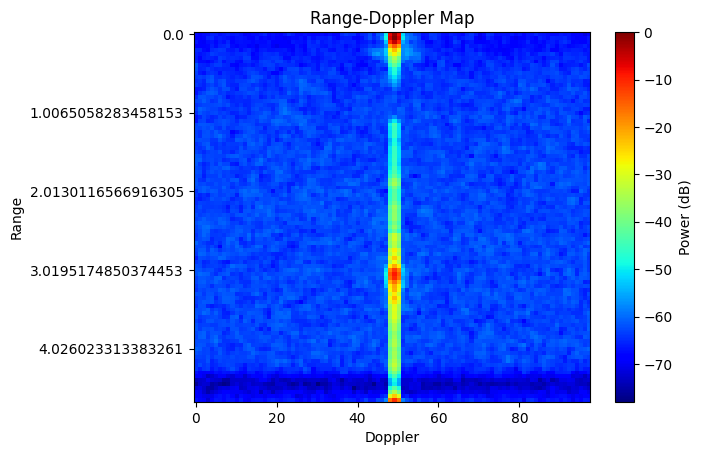

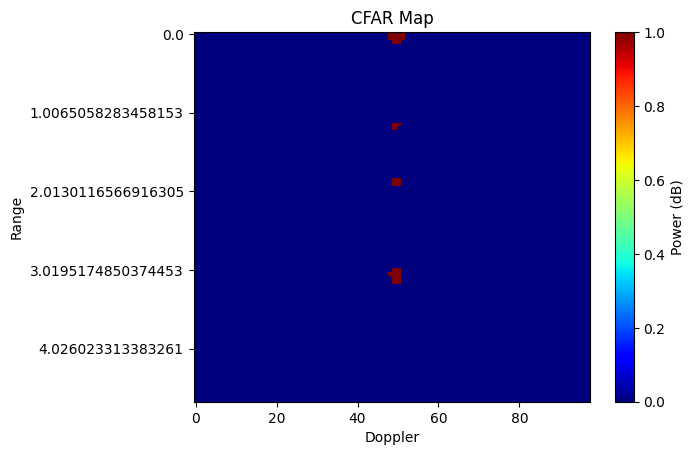

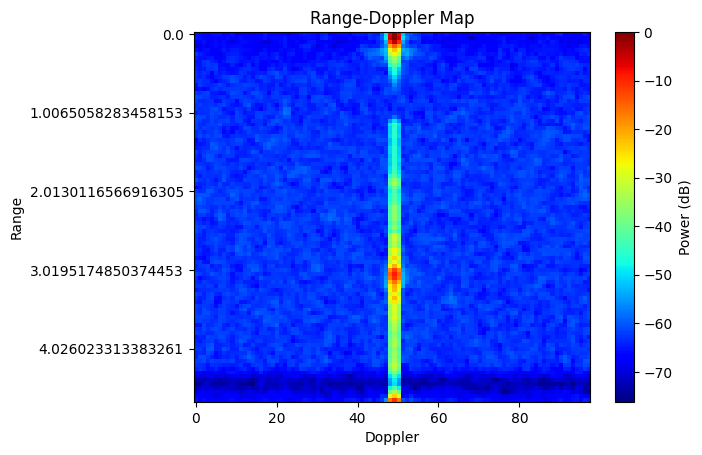

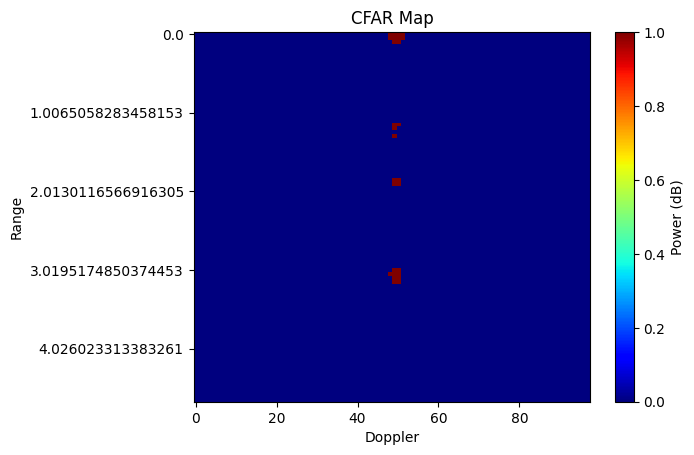

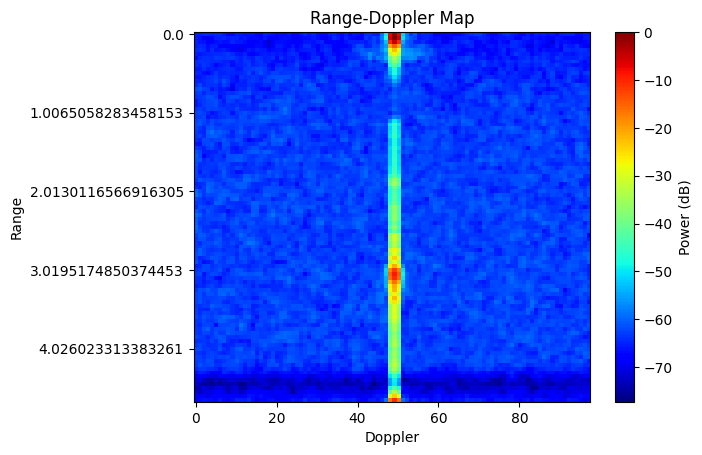

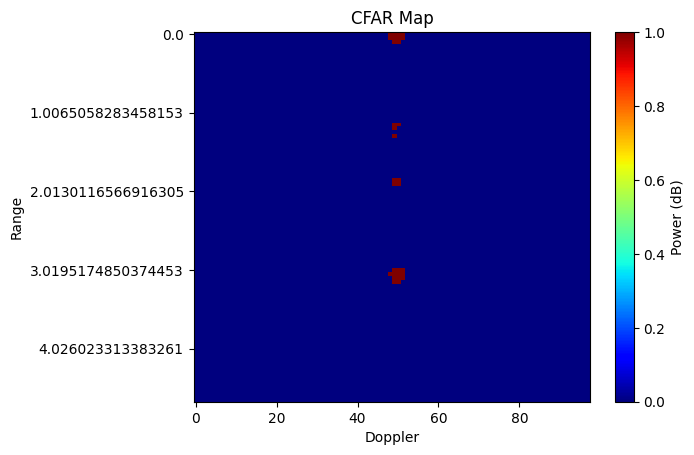

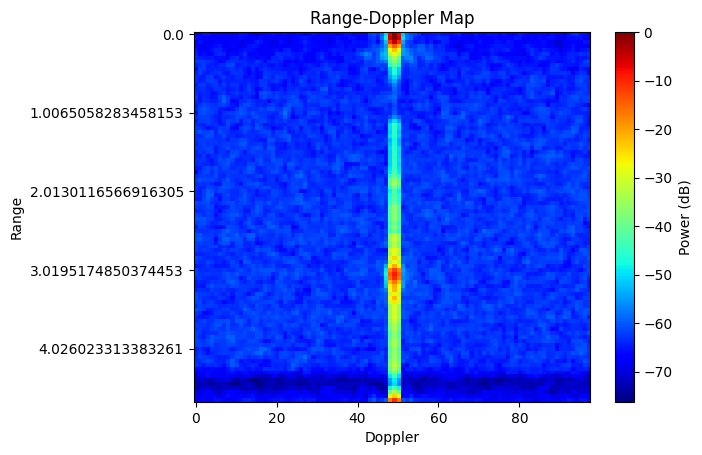

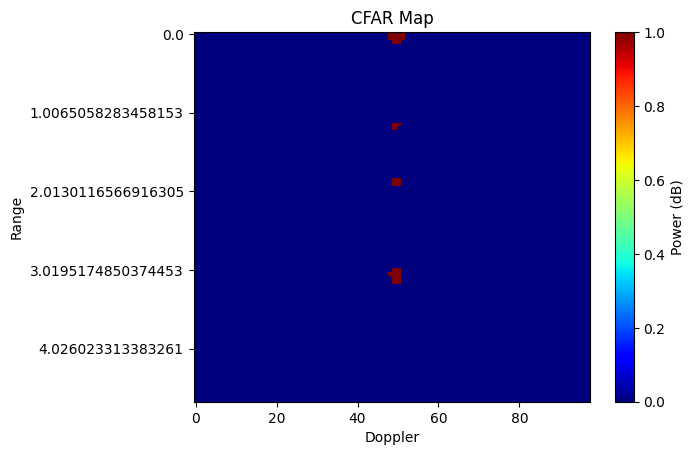

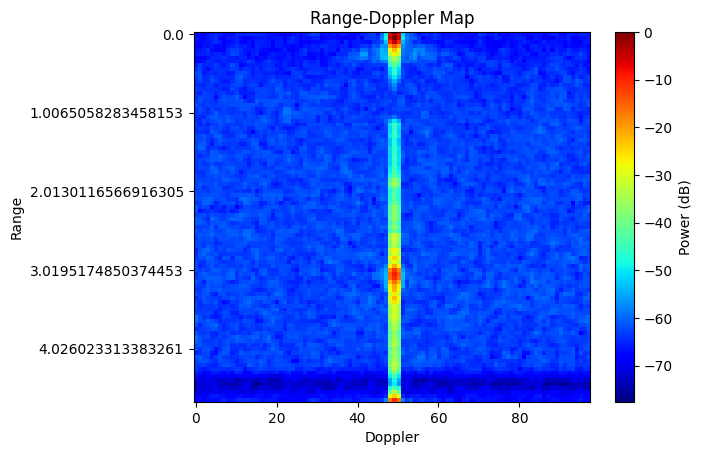

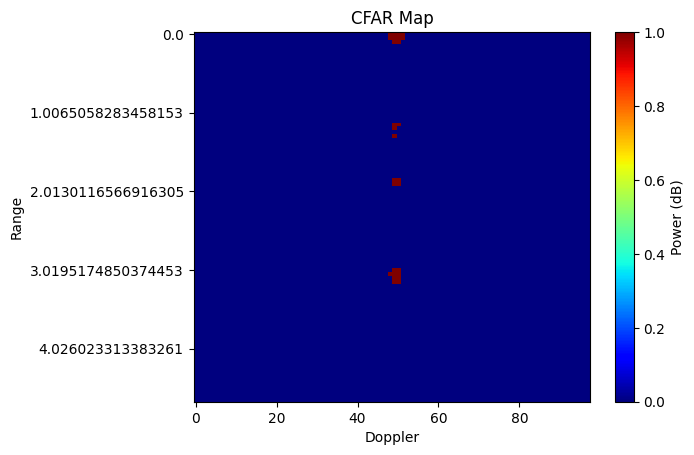

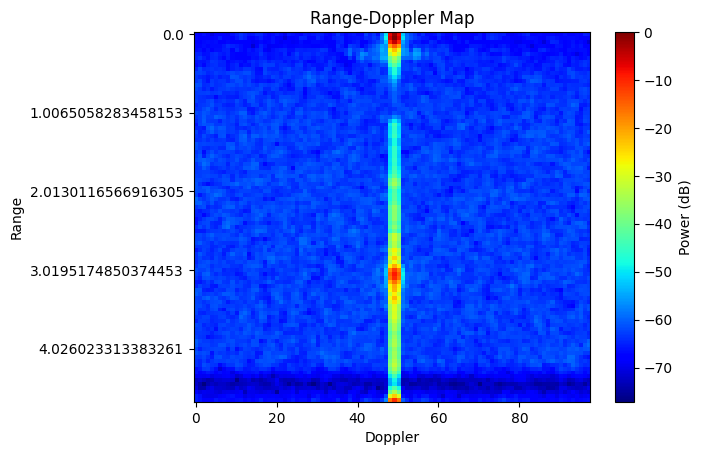

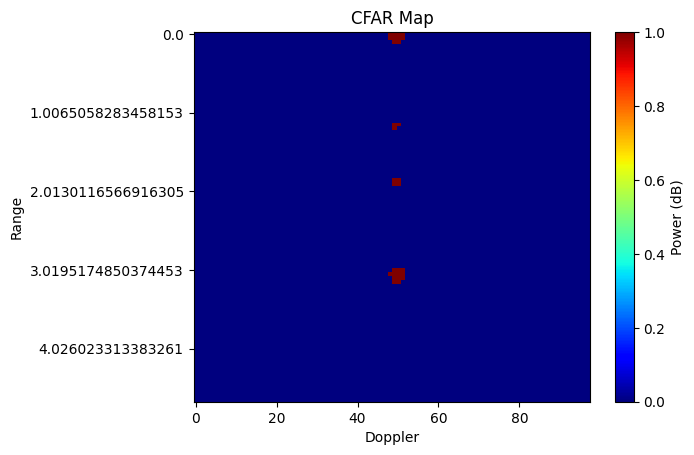

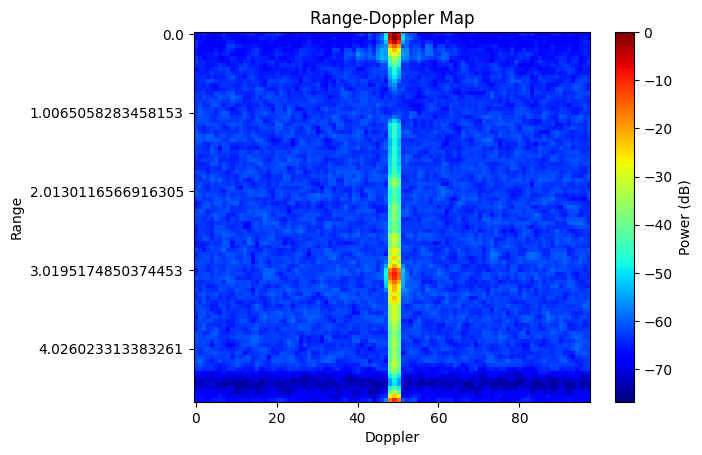

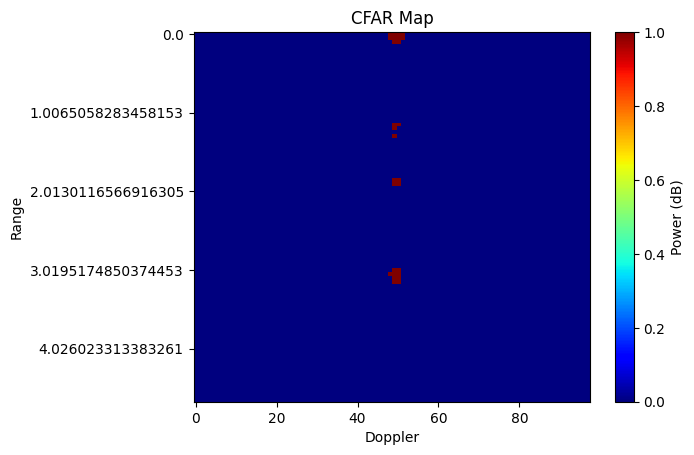

Error in callback <function flush_figures at 0x000002047FF394E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [3]:
tests_in_question = tennis_ball_tests

freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size = get_measurement_parameters(tests_in_question[0])
#range_doppler_data = range_doppler_map(test_in_question, '9', range_bin_size, False)
#cfar_data = cfar_map(range_doppler_data, 1)

# Need to take all frames of a target and generate all the maps
i = 0
for test_number in range(len(tests_in_question)):
    while True:
        try:
            rd_map = range_doppler_map(tests_in_question[test_number], i, range_bin_size, False)
            save_range_doppler_map(rd_map, range_bin_size,f'range-doppler map test {test_number} frame {i}')
            cf_map = cfar_map(rd_map, False)
            save_cfar_map(cf_map, range_bin_size, f'cfar map test {test_number} frame {i}')
            i+=1
        except: 
            i = 0
            break